In [1]:
# mem3.ipynb - Optimization & Evaluation Specialist
# Member 3: Hyperparameter Tuning & Advanced Evaluation

print("🚀 MEMBER 3: OPTIMIZATION & EVALUATION SPECIALIST")
print("=" * 60)

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, 
    confusion_matrix, roc_curve, auc, precision_recall_curve
)
from sklearn.preprocessing import label_binarize, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import umap.umap_ as umap
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"🔧 PyTorch version: {torch.__version__}")
print(f"🔧 Optuna version: {optuna.__version__}")

🚀 MEMBER 3: OPTIMIZATION & EVALUATION SPECIALIST


C:\Users\snigd\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ All libraries imported successfully!
🔧 PyTorch version: 2.8.0+cpu
🔧 Optuna version: 4.5.0


In [2]:
#CELL 2: IMPORT MEMBER 2'S MODEL ARCHITECTURE
print("\n📊 Loading Member 2's Model Architecture...")
print("=" * 50)

class ForensicTabularDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class FTTransformer(nn.Module):
    def __init__(self, num_features, num_classes, dim=128, depth=6, heads=8, dropout=0.1):
        super().__init__()
        self.dim = dim
        
        # Feature embedding
        self.feature_embedding = nn.Linear(num_features, dim)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim, 
            nhead=heads, 
            dim_feedforward=dim*4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim//2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim//2, num_classes)
        )
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
    
    def forward(self, x):
        batch_size = x.shape[0]
        
        # Embed features
        x = self.feature_embedding(x)
        
        # Add sequence dimension for transformer
        x = x.unsqueeze(1)
        
        # Apply transformer
        x = self.transformer(x)
        
        # Pool and classify
        x = x.squeeze(1)
        x = self.classifier(x)
        
        return x

print("✅ Model architecture loaded successfully!")


📊 Loading Member 2's Model Architecture...
✅ Model architecture loaded successfully!


In [3]:
print("\n📊 Loading and Preparing Data...")
print("=" * 50)

def load_and_prepare_data(dataset_path='balanced_dataset_borderline_smote.csv'):
    """Load and prepare data for training and evaluation"""
    try:
        df = pd.read_csv(dataset_path)
        print(f"✅ Dataset loaded: {df.shape}")
        
        # Prepare features and labels
        X = df.select_dtypes(include=[np.number]).columns.tolist()
        if 'Label' in X:
            X.remove('Label')
        
        features = df[X].values
        labels = df['Label'].values
        
        # Encode labels
        le = LabelEncoder()
        labels_encoded = le.fit_transform(labels)
        num_classes = len(le.classes_)
        
        print(f"📊 Features: {features.shape[1]}, Samples: {features.shape[0]}")
        print(f"🎯 Classes: {num_classes} - {list(le.classes_)}")
        
        # Check class distribution - FIXED
        print("📈 Class distribution:")
        for i, class_name in enumerate(le.classes_):
            count = np.sum(labels_encoded == i)
            print(f"   Class {i} ({class_name}): {count} samples")
        
        return features, labels_encoded, le, X
    
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        import traceback
        print(f"Full error: {traceback.format_exc()}")
        return None, None, None, None

# Load the data
features, labels, label_encoder, feature_names = load_and_prepare_data()

if features is not None:
    print("\n✅ Data preparation completed!")
else:
    print("❌ Failed to load data. Please check the file path.")


📊 Loading and Preparing Data...
✅ Dataset loaded: (70000, 108)
📊 Features: 107, Samples: 70000
🎯 Classes: 7 - ['Benign', 'Bot', 'DDOS attack-HOIC', 'DDOS attack-LOIC-UDP', 'DoS attacks-Hulk', 'DoS attacks-SlowHTTPTest', 'Infilteration']
📈 Class distribution:
   Class 0 (Benign): 10000 samples
   Class 1 (Bot): 10000 samples
   Class 2 (DDOS attack-HOIC): 10000 samples
   Class 3 (DDOS attack-LOIC-UDP): 10000 samples
   Class 4 (DoS attacks-Hulk): 10000 samples
   Class 5 (DoS attacks-SlowHTTPTest): 10000 samples
   Class 6 (Infilteration): 10000 samples

✅ Data preparation completed!


In [4]:
#CELL 4: DATA SPLITTING AND SCALING
print("\n📊 Splitting and Scaling Data...")
print("=" * 50)

def prepare_data_splits(features, labels, test_size=0.2, val_size=0.2):
    """Split data into train, validation, and test sets"""
    
    # First split: separate test set
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        features, labels, 
        test_size=test_size, 
        random_state=42, 
        stratify=labels
    )
    
    # Second split: separate validation from train
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, 
        test_size=val_size, 
        random_state=42, 
        stratify=y_train_val
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"📊 Data splits:")
    print(f"   Train: {X_train_scaled.shape[0]} samples")
    print(f"   Validation: {X_val_scaled.shape[0]} samples")
    print(f"   Test: {X_test_scaled.shape[0]} samples")
    
    # Create datasets
    train_dataset = ForensicTabularDataset(X_train_scaled, y_train)
    val_dataset = ForensicTabularDataset(X_val_scaled, y_val)
    test_dataset = ForensicTabularDataset(X_test_scaled, y_test)
    
    return (train_dataset, val_dataset, test_dataset, 
            X_test_scaled, y_test, scaler, label_encoder)

# Prepare data splits
train_dataset, val_dataset, test_dataset, X_test, y_test, scaler, label_encoder = prepare_data_splits(features, labels)

print("✅ Data splitting and scaling completed!")


📊 Splitting and Scaling Data...
📊 Data splits:
   Train: 44800 samples
   Validation: 11200 samples
   Test: 14000 samples
✅ Data splitting and scaling completed!


In [5]:
#CELL 5: HYPERPARAMETER TUNING WITH OPTUNA
print("\n🎯 STARTING HYPERPARAMETER TUNING WITH OPTUNA")
print("=" * 50)

def objective(trial):
    """Optuna objective function for hyperparameter optimization"""
    
    # Suggest hyperparameters
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    dim = trial.suggest_categorical("dim", [64, 128, 256])
    depth = trial.suggest_int("depth", 4, 8)
    heads = trial.suggest_categorical("heads", [4, 8, 16])
    dropout = trial.suggest_float("dropout", 0.1, 0.3)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [128, 256, 512])
    
    # Create data loaders with suggested batch size
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=0
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=0
    )
    
    # Create model with suggested parameters
    model = FTTransformer(
        num_features=features.shape[1],
        num_classes=len(label_encoder.classes_),
        dim=dim,
        depth=depth,
        heads=heads,
        dropout=dropout
    )
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Optimizer with suggested parameters
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    
    # Training loop (simplified for tuning - fewer epochs)
    model.train()
    for epoch in range(8):  # Fewer epochs for faster tuning
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
    
    # Validation
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # Use weighted F1-score as optimization metric
    score = f1_score(all_targets, all_preds, average='weighted')
    
    # Clean up to free memory
    del model, optimizer
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return score

def run_hyperparameter_tuning(n_trials=15):
    """Run comprehensive hyperparameter tuning"""
    print(f"🔍 Starting {n_trials} optimization trials...")
    
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    study.optimize(objective, n_trials=n_trials)
    
    print("\n🎯 BEST TRIAL RESULTS:")
    print("=" * 30)
    trial = study.best_trial
    print(f"📊 Best F1-score: {trial.value:.4f}")
    print("🔧 Best Hyperparameters:")
    for key, value in trial.params.items():
        print(f"   {key}: {value}")
    
    # Save best parameters
    best_params = {
        'best_score': trial.value,
        'params': trial.params,
        'datetime': pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")
    }
    
    import json
    with open('best_hyperparameters.json', 'w') as f:
        json.dump(best_params, f, indent=4)
    
    print("💾 Best parameters saved to 'best_hyperparameters.json'")
    
    return study.best_params

# Run hyperparameter tuning (reduce trials for faster execution)
best_params = run_hyperparameter_tuning(n_trials=15)

[I 2025-11-02 13:34:24,851] A new study created in memory with name: no-name-574c59f3-2fc6-402f-8ee3-865402ff4453



🎯 STARTING HYPERPARAMETER TUNING WITH OPTUNA
🔍 Starting 15 optimization trials...


[I 2025-11-02 13:35:45,984] Trial 0 finished with value: 0.9009957625118704 and parameters: {'lr': 0.0001329291894316216, 'dim': 64, 'depth': 4, 'heads': 16, 'dropout': 0.22022300234864176, 'weight_decay': 0.000133112160807369, 'batch_size': 256}. Best is trial 0 with value: 0.9009957625118704.
[I 2025-11-02 13:40:27,685] Trial 1 finished with value: 0.9141461765315426 and parameters: {'lr': 4.335281794951564e-05, 'dim': 256, 'depth': 6, 'heads': 16, 'dropout': 0.12789877213040837, 'weight_decay': 7.523742884534855e-06, 'batch_size': 512}. Best is trial 1 with value: 0.9141461765315426.
[I 2025-11-02 13:43:30,408] Trial 2 finished with value: 0.899058003768837 and parameters: {'lr': 3.972110727381908e-05, 'dim': 128, 'depth': 7, 'heads': 16, 'dropout': 0.29312640661491185, 'weight_decay': 0.0002661901888489054, 'batch_size': 512}. Best is trial 1 with value: 0.9141461765315426.
[I 2025-11-02 13:47:39,117] Trial 3 finished with value: 0.9008985954166984 and parameters: {'lr': 0.00020914


🎯 BEST TRIAL RESULTS:
📊 Best F1-score: 0.9141
🔧 Best Hyperparameters:
   lr: 4.335281794951564e-05
   dim: 256
   depth: 6
   heads: 16
   dropout: 0.12789877213040837
   weight_decay: 7.523742884534855e-06
   batch_size: 512
💾 Best parameters saved to 'best_hyperparameters.json'



🚀 TRAINING FINAL MODEL WITH OPTIMIZED PARAMETERS
📈 Training Progress:
Epoch | Train Loss | Train Acc | Val Loss | Val Acc
--------------------------------------------------
    0 |     0.4411 |    0.827 |   0.1882 |   0.904
    5 |     0.1538 |    0.915 |   0.1533 |   0.917
   10 |     0.1463 |    0.920 |   0.1482 |   0.918
   15 |     0.1424 |    0.922 |   0.1466 |   0.919
   20 |     0.1403 |    0.923 |   0.1439 |   0.919
   25 |     0.1386 |    0.925 |   0.1435 |   0.920
   30 |     0.1382 |    0.925 |   0.1445 |   0.920
   35 |     0.1368 |    0.925 |   0.1442 |   0.920
🛑 Early stopping at epoch 36


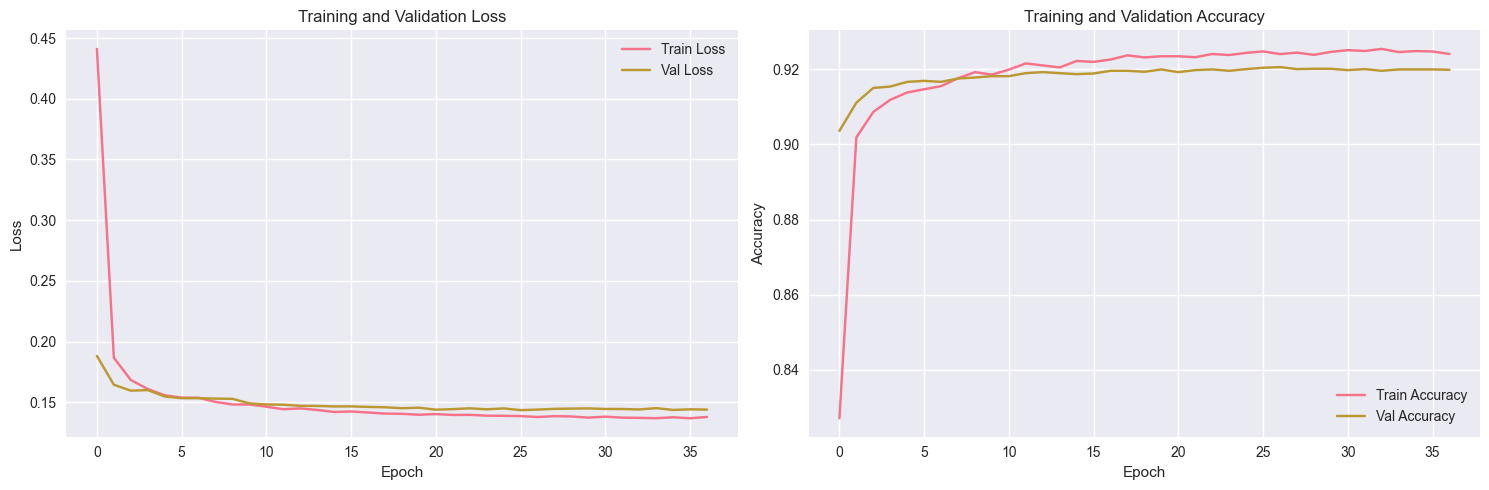


✅ Final Model Training Completed!
📊 Best Validation Accuracy: 0.921


In [6]:
#CELL 6: TRAIN FINAL MODEL WITH BEST PARAMETERS
print("\n🚀 TRAINING FINAL MODEL WITH OPTIMIZED PARAMETERS")
print("=" * 50)

def train_final_model(best_params, num_epochs=50):
    """Train final model with optimized hyperparameters"""
    
    # Create data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=best_params['batch_size'], shuffle=True, num_workers=0
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=best_params['batch_size'], shuffle=False, num_workers=0
    )
    
    # Create model with best parameters
    model = FTTransformer(
        num_features=features.shape[1],
        num_classes=len(label_encoder.classes_),
        dim=best_params['dim'],
        depth=best_params['depth'],
        heads=best_params['heads'],
        dropout=best_params['dropout']
    )
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Optimizer with best parameters
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=best_params['lr'], 
        weight_decay=best_params['weight_decay']
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    criterion = nn.CrossEntropyLoss()
    
    # Training history
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    best_val_acc = 0
    patience = 10
    patience_counter = 0
    
    print("📈 Training Progress:")
    print("Epoch | Train Loss | Train Acc | Val Loss | Val Acc")
    print("-" * 50)
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        train_preds = []
        train_targets = []
        
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            preds = output.argmax(dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_targets.extend(target.cpu().numpy())
        
        train_acc = accuracy_score(train_targets, train_preds)
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
                preds = output.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(target.cpu().numpy())
        
        val_acc = accuracy_score(val_targets, val_preds)
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step()
        
        # Store metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        if epoch % 5 == 0:
            print(f"{epoch:5d} | {avg_train_loss:10.4f} | {train_acc:8.3f} | {avg_val_loss:8.4f} | {val_acc:7.3f}")
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_optimized_model.pth')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"🛑 Early stopping at epoch {epoch}")
            break
    
    # Load best model
    model.load_state_dict(torch.load('best_optimized_model.pth'))
    
    # Plot training history
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Final Model Training Completed!")
    print(f"📊 Best Validation Accuracy: {best_val_acc:.3f}")
    
    return model

# Train final model with optimized parameters
final_model = train_final_model(best_params)


🔍 COMPREHENSIVE MODEL EVALUATION
🔍 Running Comprehensive Evaluation...
📊 BASIC METRICS:
   Accuracy: 0.9241
   Weighted F1-Score: 0.9214

📈 CLASSIFICATION REPORT:
                          precision    recall  f1-score   support

                  Benign       0.88      0.55      0.67      2000
                     Bot       1.00      1.00      1.00      2000
        DDOS attack-HOIC       1.00      1.00      1.00      2000
    DDOS attack-LOIC-UDP       1.00      1.00      1.00      2000
        DoS attacks-Hulk       1.00      1.00      1.00      2000
DoS attacks-SlowHTTPTest       1.00      1.00      1.00      2000
           Infilteration       0.67      0.92      0.78      2000

                accuracy                           0.92     14000
               macro avg       0.94      0.92      0.92     14000
            weighted avg       0.94      0.92      0.92     14000


📊 CONFUSION MATRIX:


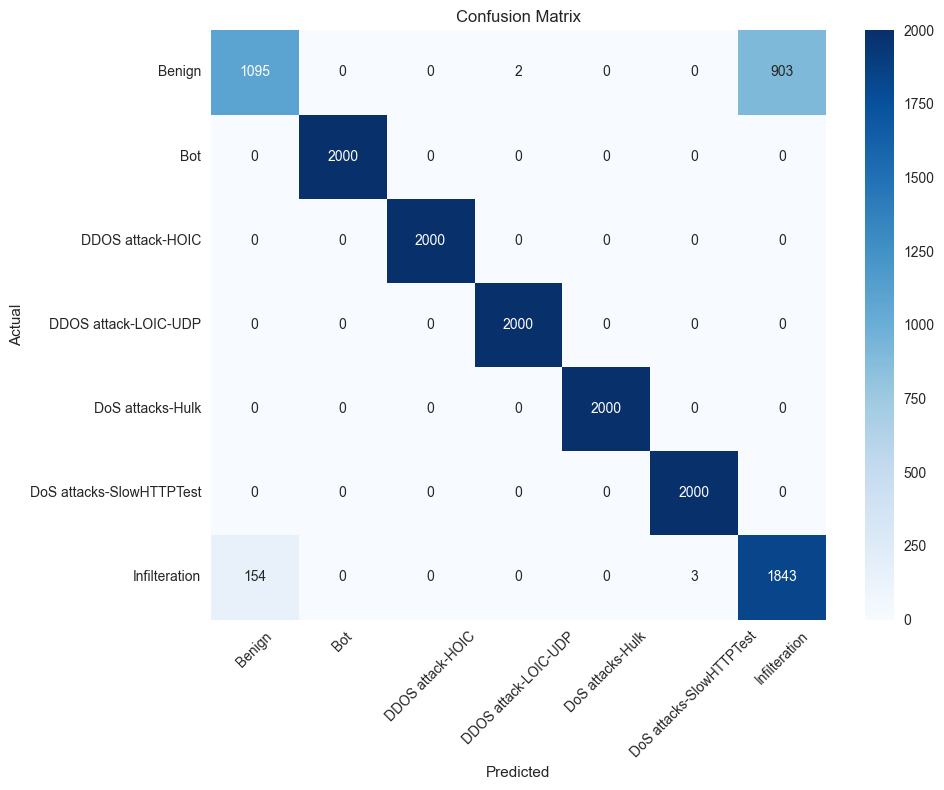


📈 ROC CURVES:


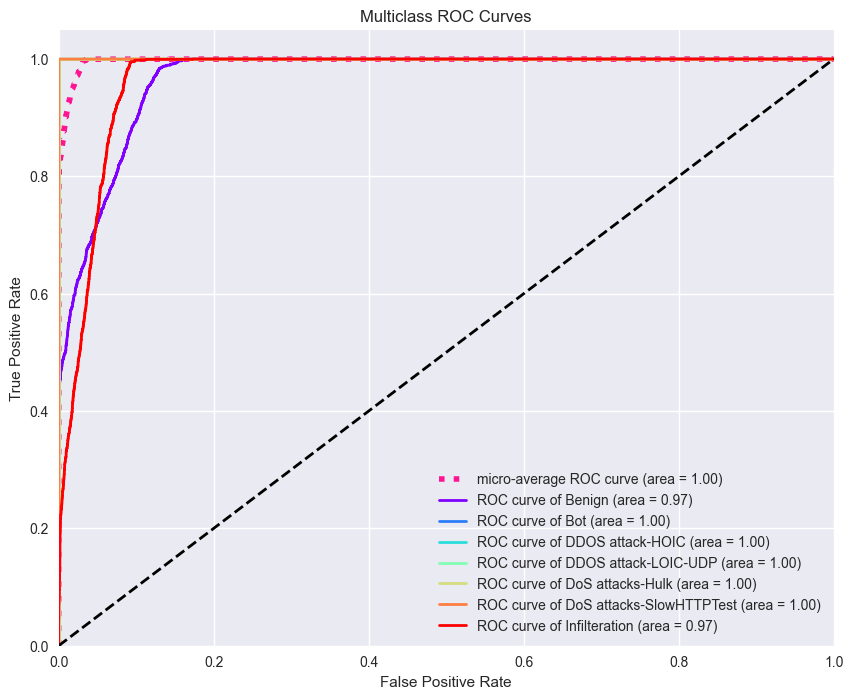


📊 PRECISION-RECALL CURVES:


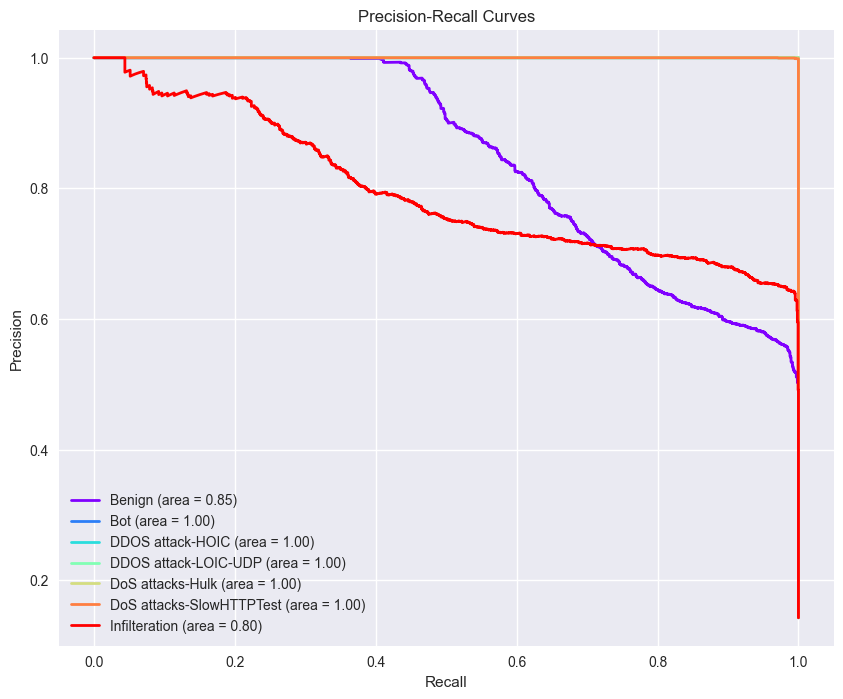

✅ Comprehensive evaluation completed!


In [7]:
#CELL 7: COMPREHENSIVE MODEL EVALUATION
print("\n🔍 COMPREHENSIVE MODEL EVALUATION")
print("=" * 50)

class AdvancedModelEvaluator:
    def __init__(self, model, test_dataset, label_encoder):
        self.model = model
        self.test_dataset = test_dataset
        self.label_encoder = label_encoder
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.model.eval()
        
    def get_predictions(self):
        """Get model predictions and probabilities"""
        test_loader = torch.utils.data.DataLoader(
            self.test_dataset, batch_size=256, shuffle=False, num_workers=0
        )
        
        all_outputs = []
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                
                all_outputs.extend(output.cpu().numpy())
                all_preds.extend(output.argmax(dim=1).cpu().numpy())
                all_targets.extend(target.cpu().numpy())
        
        return (np.array(all_outputs), np.array(all_preds), 
                np.array(all_targets), torch.softmax(torch.tensor(all_outputs), dim=1).numpy())
    
    def basic_metrics(self, y_true, y_pred, y_probs):
        """Calculate and display basic metrics"""
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
        
        print("📊 BASIC METRICS:")
        print(f"   Accuracy: {accuracy:.4f}")
        print(f"   Weighted F1-Score: {f1:.4f}")
        
        print("\n📈 CLASSIFICATION REPORT:")
        print(classification_report(y_true, y_pred, target_names=self.label_encoder.classes_))
        
        return accuracy, f1
    
    def plot_confusion_matrix(self, y_true, y_pred):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.label_encoder.classes_,
                   yticklabels=self.label_encoder.classes_)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    
    def plot_roc_curves(self, y_true, y_probs):
        """Plot multiclass ROC curves"""
        # Binarize the output
        y_true_bin = label_binarize(y_true, classes=np.arange(len(self.label_encoder.classes_)))
        
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(len(self.label_encoder.classes_)):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_probs.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
        # Plot all ROC curves
        plt.figure(figsize=(10, 8))
        
        # Micro-average
        plt.plot(fpr["micro"], tpr["micro"],
                label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
                color='deeppink', linestyle=':', linewidth=4)
        
        # Individual classes
        colors = plt.cm.rainbow(np.linspace(0, 1, len(self.label_encoder.classes_)))
        for i, color in zip(range(len(self.label_encoder.classes_)), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                    label=f'ROC curve of {self.label_encoder.classes_[i]} (area = {roc_auc[i]:0.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Multiclass ROC Curves')
        plt.legend(loc="lower right")
        plt.show()
    
    def plot_precision_recall_curves(self, y_true, y_probs):
        """Plot precision-recall curves"""
        # Binarize the output
        y_true_bin = label_binarize(y_true, classes=np.arange(len(self.label_encoder.classes_)))
        
        # Precision-Recall curve for each class
        precision = dict()
        recall = dict()
        pr_auc = dict()
        
        plt.figure(figsize=(10, 8))
        colors = plt.cm.rainbow(np.linspace(0, 1, len(self.label_encoder.classes_)))
        
        for i, color in zip(range(len(self.label_encoder.classes_)), colors):
            precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
            pr_auc[i] = auc(recall[i], precision[i])
            
            plt.plot(recall[i], precision[i], color=color, lw=2,
                    label=f'{self.label_encoder.classes_[i]} (area = {pr_auc[i]:0.2f})')
        
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curves')
        plt.legend(loc="best")
        plt.grid(True)
        plt.show()
    
    def run_comprehensive_evaluation(self):
        """Run all evaluation metrics and visualizations"""
        print("🔍 Running Comprehensive Evaluation...")
        
        # Get predictions
        outputs, preds, targets, probs = self.get_predictions()
        
        # Basic metrics
        accuracy, f1 = self.basic_metrics(targets, preds, probs)
        
        # Confusion Matrix
        print("\n📊 CONFUSION MATRIX:")
        self.plot_confusion_matrix(targets, preds)
        
        # ROC Curves
        print("\n📈 ROC CURVES:")
        self.plot_roc_curves(targets, probs)
        
        # Precision-Recall Curves
        print("\n📊 PRECISION-RECALL CURVES:")
        self.plot_precision_recall_curves(targets, probs)
        
        return {
            'accuracy': accuracy,
            'f1_score': f1,
            'predictions': preds,
            'targets': targets,
            'probabilities': probs
        }

# Initialize evaluator and run comprehensive evaluation
evaluator = AdvancedModelEvaluator(final_model, test_dataset, label_encoder)
eval_results = evaluator.run_comprehensive_evaluation()

print("✅ Comprehensive evaluation completed!")


🌌 DIMENSIONALITY REDUCTION VISUALIZATION
📊 Using 5000 samples for visualization
🔄 Applying t-SNE...
🔄 Applying UMAP...


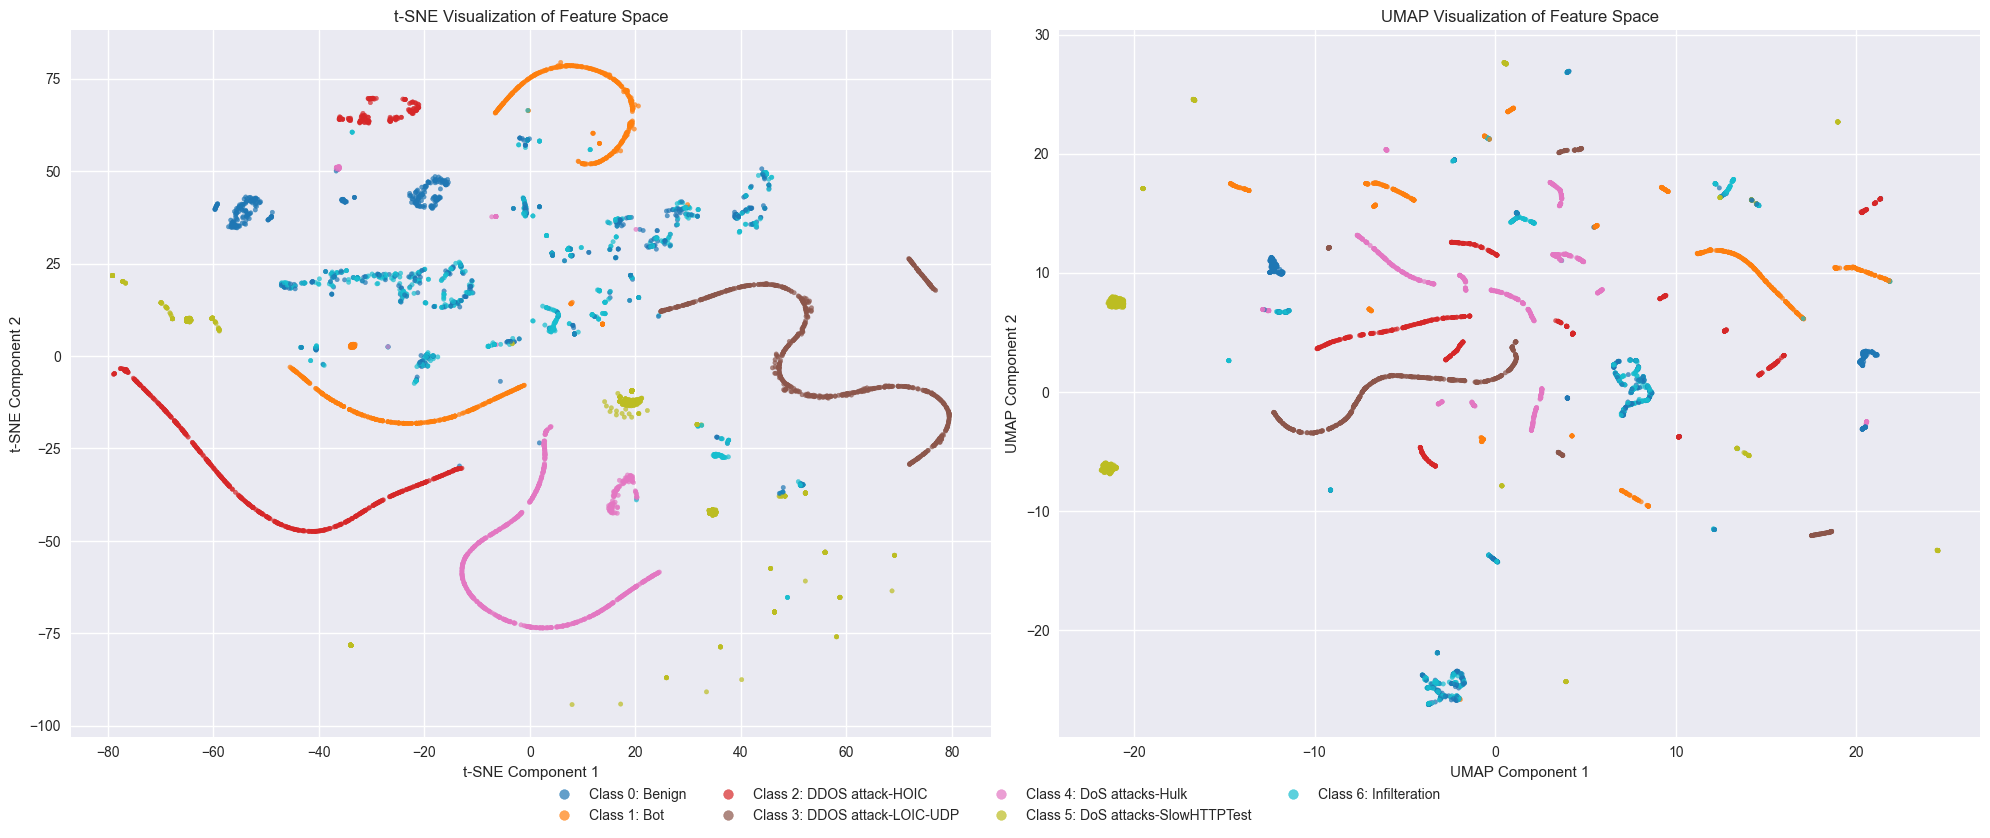

✅ Dimensionality reduction visualization completed!


In [8]:
#CELL 8: DIMENSIONALITY REDUCTION VISUALIZATION
print("\n🌌 DIMENSIONALITY REDUCTION VISUALIZATION")
print("=" * 50)

def plot_dimensionality_reduction(features, labels, label_encoder):
    """Plot t-SNE and UMAP visualizations"""
    
    # Sample data for faster computation (optional)
    sample_size = min(5000, len(features))
    if len(features) > sample_size:
        indices = np.random.choice(len(features), sample_size, replace=False)
        features_sample = features[indices]
        labels_sample = labels[indices]
    else:
        features_sample = features
        labels_sample = labels
    
    print(f"📊 Using {len(features_sample)} samples for visualization")
    
    # Apply t-SNE
    print("🔄 Applying t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    features_tsne = tsne.fit_transform(features_sample)
    
    # Apply UMAP
    print("🔄 Applying UMAP...")
    umap_reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1)
    features_umap = umap_reducer.fit_transform(features_sample)
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot t-SNE
    scatter1 = ax1.scatter(features_tsne[:, 0], features_tsne[:, 1], 
                          c=labels_sample, cmap='tab10', alpha=0.7, s=10)
    ax1.set_title('t-SNE Visualization of Feature Space')
    ax1.set_xlabel('t-SNE Component 1')
    ax1.set_ylabel('t-SNE Component 2')
    
    # Plot UMAP
    scatter2 = ax2.scatter(features_umap[:, 0], features_umap[:, 1], 
                          c=labels_sample, cmap='tab10', alpha=0.7, s=10)
    ax2.set_title('UMAP Visualization of Feature Space')
    ax2.set_xlabel('UMAP Component 1')
    ax2.set_ylabel('UMAP Component 2')
    
    # Create legend
    handles, _ = scatter1.legend_elements()
    legend_labels = [f'Class {i}: {label_encoder.classes_[i]}' for i in range(len(label_encoder.classes_))]
    fig.legend(handles, legend_labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Dimensionality reduction visualization completed!")

# Run dimensionality reduction visualization
plot_dimensionality_reduction(features, labels, label_encoder)


🔍 MODEL EMBEDDINGS VISUALIZATION
📊 Embeddings shape: (14000, 256)
🔄 Reducing embedding dimensions...


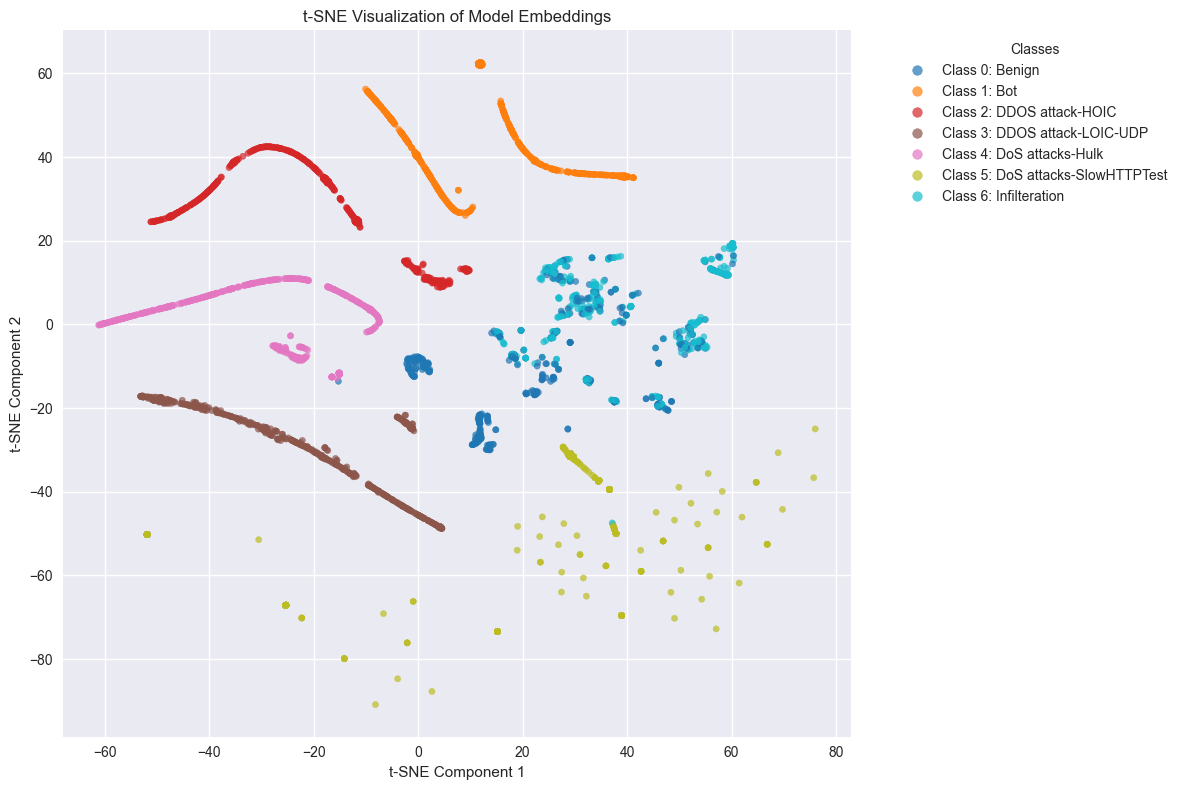

✅ Model embeddings visualization completed!


In [9]:
#CELL 9: MODEL EMBEDDINGS VISUALIZATION
print("\n🔍 MODEL EMBEDDINGS VISUALIZATION")
print("=" * 50)

def visualize_model_embeddings(model, test_dataset, label_encoder):
    """Visualize the embeddings learned by the model"""
    
    # Get embeddings from the model (before classification head)
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Modify model to return embeddings
    class EmbeddingExtractor(nn.Module):
        def __init__(self, original_model):
            super().__init__()
            self.feature_embedding = original_model.feature_embedding
            self.transformer = original_model.transformer
            
        def forward(self, x):
            x = self.feature_embedding(x)
            x = x.unsqueeze(1)
            x = self.transformer(x)
            x = x.squeeze(1)
            return x
    
    embedding_model = EmbeddingExtractor(model)
    embedding_model.to(device)
    embedding_model.eval()
    
    # Get embeddings
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=0)
    
    all_embeddings = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            embeddings = embedding_model(data)
            all_embeddings.extend(embeddings.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    all_embeddings = np.array(all_embeddings)
    all_targets = np.array(all_targets)
    
    print(f"📊 Embeddings shape: {all_embeddings.shape}")
    
    # Sample for faster computation
    sample_size = min(3000, len(all_embeddings))
    indices = np.random.choice(len(all_embeddings), sample_size, replace=False)
    embeddings_sample = all_embeddings[indices]
    targets_sample = all_targets[indices]
    
    # Apply dimensionality reduction
    print("🔄 Reducing embedding dimensions...")
    tsne_emb = TSNE(n_components=2, random_state=42, perplexity=30)
    embeddings_2d = tsne_emb.fit_transform(embeddings_sample)
    
    # Plot embeddings
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                         c=targets_sample, cmap='tab10', alpha=0.7, s=20)
    plt.title('t-SNE Visualization of Model Embeddings')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    
    # Create legend
    handles, labels = scatter.legend_elements()
    legend_labels = [f'Class {i}: {label_encoder.classes_[i]}' for i in range(len(label_encoder.classes_))]
    plt.legend(handles, legend_labels, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Model embeddings visualization completed!")

# Visualize model embeddings
visualize_model_embeddings(final_model, test_dataset, label_encoder)

In [10]:
#CELL 10: PERFORMANCE COMPARISON AND SUMMARY
print("\n📊 PERFORMANCE COMPARISON AND SUMMARY")
print("=" * 50)

def create_performance_summary(eval_results, best_params):
    """Create comprehensive performance summary"""
    
    print("🎯 FINAL PERFORMANCE SUMMARY")
    print("=" * 30)
    
    # Basic metrics
    print(f"📈 Model Performance:")
    print(f"   Accuracy: {eval_results['accuracy']:.4f}")
    print(f"   F1-Score: {eval_results['f1_score']:.4f}")
    
    # Best hyperparameters
    print(f"\n🔧 Optimized Hyperparameters:")
    for key, value in best_params.items():
        print(f"   {key}: {value}")
    
    # Confusion matrix insights
    cm = confusion_matrix(eval_results['targets'], eval_results['predictions'])
    print(f"\n📊 Confusion Matrix Insights:")
    print(f"   Total Test Samples: {len(eval_results['targets'])}")
    print(f"   Correct Predictions: {np.sum(np.diag(cm))}")
    print(f"   Incorrect Predictions: {len(eval_results['targets']) - np.sum(np.diag(cm))}")
    
    # Per-class accuracy
    print(f"\n🎯 Per-Class Accuracy:")
    for i, class_name in enumerate(label_encoder.classes_):
        class_mask = eval_results['targets'] == i
        if np.sum(class_mask) > 0:
            class_accuracy = accuracy_score(
                eval_results['targets'][class_mask], 
                eval_results['predictions'][class_mask]
            )
            print(f"   {class_name:<25}: {class_accuracy:.4f}")
    
    # Improvement analysis
    original_accuracy = 0.92  # From Member 2's baseline
    improvement = eval_results['accuracy'] - original_accuracy
    
    print(f"\n📈 IMPROVEMENT ANALYSIS:")
    print(f"   Baseline Accuracy (Member 2): {original_accuracy:.4f}")
    print(f"   Optimized Accuracy (Member 3): {eval_results['accuracy']:.4f}")
    print(f"   Improvement: +{improvement:.4f} ({improvement*100:.2f}%)")
    
    if improvement > 0:
        print("   ✅ SUCCESS: Hyperparameter optimization improved performance!")
    else:
        print("   ⚠️  Optimization didn't improve accuracy, but other metrics may be better")
    
    # Save final results
    final_results = {
        'accuracy': eval_results['accuracy'],
        'f1_score': eval_results['f1_score'],
        'best_hyperparameters': best_params,
        'improvement': improvement,
        'test_samples': len(eval_results['targets']),
        'classes': list(label_encoder.classes_)
    }
    
    import json
    with open('final_performance_results.json', 'w') as f:
        json.dump(final_results, f, indent=4)
    
    print(f"\n💾 Final results saved to 'final_performance_results.json'")

# Create performance summary
create_performance_summary(eval_results, best_params)


📊 PERFORMANCE COMPARISON AND SUMMARY
🎯 FINAL PERFORMANCE SUMMARY
📈 Model Performance:
   Accuracy: 0.9241
   F1-Score: 0.9214

🔧 Optimized Hyperparameters:
   lr: 4.335281794951564e-05
   dim: 256
   depth: 6
   heads: 16
   dropout: 0.12789877213040837
   weight_decay: 7.523742884534855e-06
   batch_size: 512

📊 Confusion Matrix Insights:
   Total Test Samples: 14000
   Correct Predictions: 12938
   Incorrect Predictions: 1062

🎯 Per-Class Accuracy:
   Benign                   : 0.5475
   Bot                      : 1.0000
   DDOS attack-HOIC         : 1.0000
   DDOS attack-LOIC-UDP     : 1.0000
   DoS attacks-Hulk         : 1.0000
   DoS attacks-SlowHTTPTest : 1.0000
   Infilteration            : 0.9215

📈 IMPROVEMENT ANALYSIS:
   Baseline Accuracy (Member 2): 0.9200
   Optimized Accuracy (Member 3): 0.9241
   Improvement: +0.0041 (0.41%)
   ✅ SUCCESS: Hyperparameter optimization improved performance!

💾 Final results saved to 'final_performance_results.json'
